# Water Observations from Space (WOFS)

### Background

Understanding Virginia's flood history is an important part of making better predictions about how we will be affected by flooding in the future.

To this end, we utilize the Australian WOFS analysis to make detection studies of our region. Geoscience Australia developed the Australian Water Observations from Space (WOFS) algorithm. WOFS provides an estimate of how often water was seen at a particular location. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 

For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

## Preliminary steps

In [1]:
# Suppress Warning 
import warnings
warnings.filterwarnings('ignore')

# Connect to AWS
from datacube.utils.aws import configure_s3_access
configure_s3_access(requester_pays=True)

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'Norfolk_WOFS')

# Import ODC UI
from odc.ui import with_ui_cbk 

# Import load_ard
from deafrica_tools.datahandling import load_ard

# Import other required packages
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr 

## Define product and extent

In [3]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a product and platform
platform = "LANDSAT_8"
products=['ls8_c2l2_sr']

# Make sure to appropriately change the resolution when you change the CRS
resolution = (-0.000269494585236, 0.000269494585236)
output_crs = 'EPSG:4326'

### Set extent information

You can change the values in this cell to specify the extent of the data cube you wish to analyse.

You should select a sub-sample from one of the four data cubes listed above. When subsampling, keep in mind that:
* Your latitude and longitude bounds should be within the extents given.
* Your area should be small to keep load times reasonable (less than 0.5 square degrees).
* Your time period should be within the extents given.

You should format the variables as:
* `latitude = (min_latitude, max_latitude)`
* `longitude = (min_longitude, max_longitude)`
* `time_extents = (min_time, max_time)`, where each time has the format: `'YYYY-MM-DD'`.

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a sub-region to analyse

# Downtown Norfolk
lon, lat = -76.288891,36.879827 
buffer = 0.05

# Norfolk Naval Pier 14
# lon, lat = -76.326891,36.959827 
# buffer = 0.025

lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)
time_extents = ('2021-01', '2022-01')

### View the region before loading

The next cell will allow you to view the area you'll be analysing by displaying a red bounding box on an interactive map. You can change the extents in the previous cell and rerun the `display_map()` command to see the resulting bounding box.

In [5]:
# The code below renders a map that can be used to view the analysis region.
from utils.dc_display_map import display_map

display_map(lat_range, lon_range)

## Load the dataset and the required spectral bands or other parameters
The data is loaded by passing the product and area information to the `dc.load()` function. As a part of this load, we also specify the measurements we want in the form of the Landsat bands.

The load can take up to a few minutes, so please be patient.

In [6]:
# Load the data
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_extents,
    "output_crs": output_crs,
    "resolution": resolution,
    "measurements": ['red',
                    'green',
                    'blue',
                    'nir08',
                    'swir_1',
                    'swir_2',
                    'pixel_qa',],
}

landsat_dataset = load_ard(
    dc=dc,
    platform=platform,
    products=products,
    min_gooddata=0.9,
    group_by="solar_day",
    **query)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_c2l2_sr
Counting good quality pixels for each time step
Filtering to 7 out of 21 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 7 time steps


It is often useful to print the loaded data to check the dimensions and data variables

When looking at the dimensions, the numbers for latitude and longitude correspond to the number of pixels in each dimension and the number for time corresponds to the number of time steps. 

In [7]:
# Displays an overview of the loaded data
landsat_dataset

<xarray.Dataset>
Dimensions:      (time: 7, latitude: 372, longitude: 372)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T15:40:48.109005 ... 2021-11...
  * latitude     (latitude) float64 36.93 36.93 36.93 ... 36.83 36.83 36.83
  * longitude    (longitude) float64 -76.34 -76.34 -76.34 ... -76.24 -76.24
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) float32 0.0362 0.03623 ... 0.03922
    green        (time, latitude, longitude) float32 0.04629 0.04629 ... 0.03721
    blue         (time, latitude, longitude) float32 0.01733 0.01634 ... 0.02426
    nir08        (time, latitude, longitude) float32 7.185e+03 ... 1.311e+04
    swir_1       (time, latitude, longitude) float32 6.25e-05 ... 0.07902
    swir_2       (time, latitude, longitude) float32 0.0009975 ... 0.03809
    pixel_qa     (time, latitude, longitude) float32 2.195e+04 ... 2.182e+04
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

## Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

The first step is to classify the dataset, which can be done with the `wofs_classify()` utility function.

In [8]:
from utils.dc_water_classifier import wofs_classify

ts_water_classification = wofs_classify(landsat_dataset)

ts_water_classification

<xarray.Dataset>
Dimensions:      (time: 7, latitude: 372, longitude: 372)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T15:40:48.109005 ... 2021-11...
  * latitude     (latitude) float64 36.93 36.93 36.93 ... 36.83 36.83 36.83
  * longitude    (longitude) float64 -76.34 -76.34 -76.34 ... -76.24 -76.24
    spatial_ref  int32 4326
Data variables:
    wofs         (time, latitude, longitude) int16 1 1 1 1 1 1 1 ... 1 1 0 0 0 1

The next step is to convert "no data" pixels to `nan`. A "no data" pixel has a value of `-9999` in Landsat data.

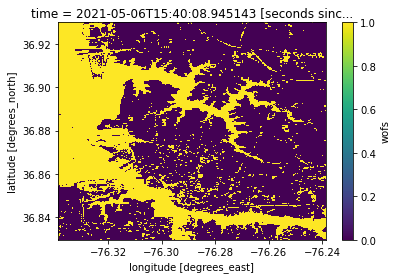

In [9]:
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float32)

ts_water_classification["wofs"][1].plot()

Finally, the percentage of time that a pixel is classified as water is calculated by taking the average classification value over time and multiplying it by 100. The mean calculation ignores `nan` values.

In [10]:
water_classification_percentages = (ts_water_classification.mean(dim=['time']) * 100).wofs.rename('water_classification_percentages')

## Exploring the results

After calculating the water classification percentage, we can plot it both as a 2-dimensional image and 1-dimensional summary.

The first step is to choose a colour map and change the colour of `nan` pixels to black. We choose to use the `RdBu` colour map to highlight water in blue and land in red.

In [11]:
# import color-scheme and set nans to black
from matplotlib.cm import RdBu
RdBu.set_bad('black', 1)

In the following figure, dark blue indicates pixels that experienced significant or constant water over the time series, where dark red indicates pixels that have experienced little or no water over the time series.

You can adjust the figure size to avoid distortion. Use the `latitude` and `longitude` dimensions from the `xarray` description to get an idea for the desired aspect ratio. You'll need to add some space in the x-dimension to account for the presence of the colour bar. 

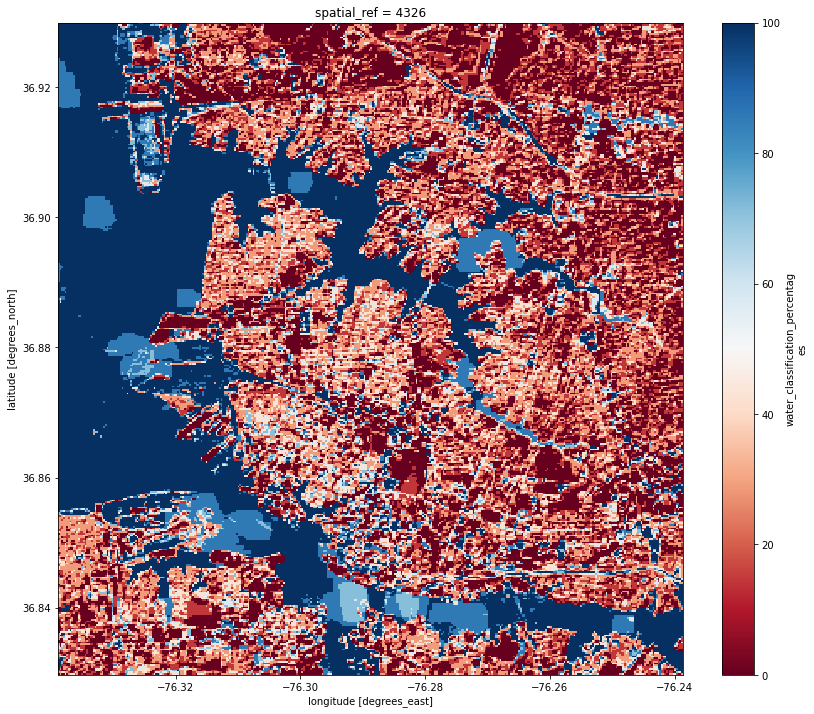

In [12]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

water_classification_percentages.plot(cmap=RdBu, figsize=(14, 12))
plt.show()

By taking the average classification value over the latitude and longitude, we can assess whether the fraction of water pixels has changed significantly over time. It should be noted that clouds can impact the statistical results. The water classification percentage can be displayed on either a linear scale or a logarithmic scale.

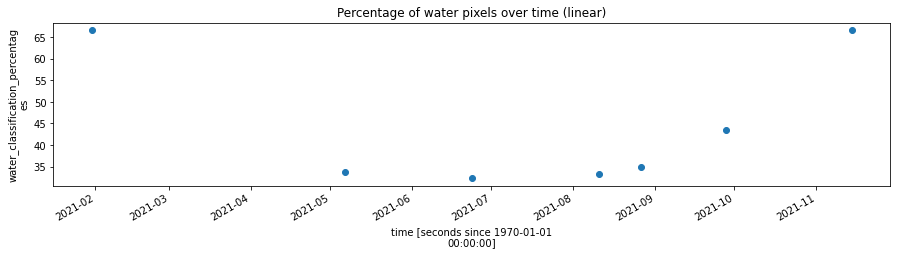

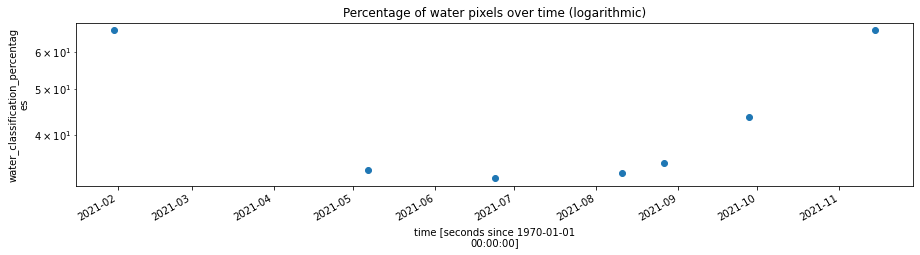

In [13]:
water_classification_mean_percentages = (ts_water_classification.mean(dim=['latitude', 'longitude']) * 100).wofs.rename('water_classification_percentages')

#Linear-scale plot
water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.title("Percentage of water pixels over time (linear)")
plt.show()

#Logarithmic-scale plot
water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.title("Percentage of water pixels over time (logarithmic)")
plt.gca().set_yscale('log')

## Export to GeoTIFF
To perform further analysis, use the following cells to download the data in GeoTIFF format. This makes use of the data cube utility function `export_slice_to_geotiff()`. 

Before exporting, we'll construct an `xarray` dataset to store the water classification percentage data we created earlier.

In [14]:
# Save the water percentage data to a GeoTIFF
from utils.import_export import export_slice_to_geotiff

# construct the xarray Dataset
dataset_to_export = xr.Dataset(coords=water_classification_percentages.coords, attrs=ts_water_classification.attrs)

# add the water classification percentages to the new xarray Dataset
dataset_to_export['wofs_pct'] = (water_classification_percentages/100).astype(np.float32)

The export command on the following line is commented out to avoid overwriting files. If you would like to export data, please change the filename before uncommenting the next line.

In [15]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>>>>>>

export_slice_to_geotiff(dataset_to_export, 'geotiffs/WOFS_Percentage_demo.tif')

TypeError: write_geotiff_from_xr() got an unexpected keyword argument 'dataset'

By default, the files have been saved in the `geotiffs` folder, which sits inside the `dcal` folder that this notebook is stored in. Use the following cell to list the contents of the `geotiffs` folder.

*NOTE:* Starting a command with `!` allows you to run that command in the Jupyter environment's command line.

In [ ]:
!ls -lah geotiffs/